In [1]:
import pandas as pd
import pylab
import json
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from IPython.core import display
import psycopg2
import os
homedir = os.getenv("HOME")
with open(homedir + "/.pgpass",'r') as pgfile:
    pgdat = pgfile.read().strip().split(":")
    pgurl = pgdat[0]
    pgport = pgdat[1]
    pgdb = pgdat[2]
    pguser = pgdat[3]
    pgpass = pgdat[4]

%load_ext sql
from sqlalchemy import create_engine
# sql info: https://github.com/catherinedevlin/ipython-sql
#uncomment for remote
pgport=3333
# pgport=5433
engine = create_engine('postgresql://postgres@localhost:%i/postgres' % pgport)
db = psycopg2.connect(host=pgurl, database=pgdb, user=pguser,password=pgpass,port=pgport)

/Users/shawnmeier/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Experimental notes
- [ ] Choose 10 apps (5 from fdroid and 5 from google samples) - sample dereference locations
- [ ] results with no framework model - numbers alarm, proven, timeout
- [ ] specify something from documentation (fragment/activity lifecycle)
- [ ] try with existing model from 4 pull request specs
- [ ] (most optional) choose some locations and manually write the specs
- [ ] look into how to run pipeline with infer/error prone
- [ ] look at nullaway
- [ ] does nullaway/infer/etc have a benchmark set that we could use?
- [ ] would like infer as a comparison for 4 pull requests

priority minimum bar by mar 15th (ok to need some more compute or re-run, but draft results):
1. run the generalizability experiment on 10 apps with some specicfication refinement (without infer)
1. run infer on pr examples

notes apr 1 2022:

Would like to know what the parameters of the experiment will be by 15th

most important number: %proven
filteting experiment: start with running on 2k deref sites report alarms, filter alarms based on lifecycle

Is our counter example something that can reproduce the bug? Is the witness trace reaalizable?

We are at least getting to the capability of being able to report the order of callbacks that likely witnesses the callbacks.  Typical analysi only says we get an alarm.  We try our best to get to a proof, but if we stop, we say we have explored all cb order up to depth k and still have not found the alarm.  Every time we find an alarm, it turns out to be something realizeable.

hypothesis: every true alarm is realizable in under 10 callbacks

evaluation criteria for "is this a realizable trace?": I android expert (c) examined it and it appears to be real.  Get a sense of how hard it would be to use this tool. Generalizability study is the test for this.


time how long it takes shawn to write extra specsf: hrs

Threat to validity: I am the tool developer and measuring my success with it, but it is a reasonable proxy for "expert tool user"

"usefullness research question"

we can say that widening is out of scope for this paper (next paper will address this)


In [2]:
def qry(q):
  return pd.read_sql_query(con = db, sql = q)
# pd.set_option("max_colwidth", None)
# pd.set_option('display.max_columns', None)
pd.set_option("display.latex.repr", False)
pd.set_option("display.latex.escape", True)

def iDisplay(v):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, "max_colwidth", None):
        display.display(v)


In [3]:
%%sql postgresql://postgres@localhost:$pgport/postgres
select count(*) from apks where apkname not like 'jar_%' and apkname not like 'spec_%';

1 rows affected.


count
5


In [4]:
%%sql
select 
    (select count(*) from jobs where status = 'completed') as Completed_Jobs,
    (select count(*) from jobs where status = 'paused') as Paused_Jobs,
    (select count(*) from jobs where status = 'acquired') as Acquired_jobs,
    (select count(id) from jobs 
       where stderr like '%Exception%no active body present for method%') as Body_Exception,
    (select count(id) from jobs where stderr like '%Exception%') as Exception,
    (select count(id) from jobs where stderr like '%Failed t
     o parse reflective type reference%') as Refl_exception,
    (select count(id) from jobs where status like 'failed%') as worker_failure,
    (select count(id) from jobs where stdout like '%empty pred lZocation%') as possible_cg_unsound,
    (select count(*) from jobs) as Total_Jobs

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


completed_jobs,paused_jobs,acquired_jobs,body_exception,exception,refl_exception,worker_failure,possible_cg_unsound,total_jobs
90,0,0,0,0,0,0,0,90


18: 10:12 pm
20: 10:16 pm
24: 11:26 pm

Failing apks

In [5]:
%%sql
select cast(config::json->'apkPath' as text) from jobs 
        where stderr like '%Exception' group by cast(config::json->'apkPath' as text) ;

 * postgresql://postgres@localhost:3333/postgres
0 rows affected.


text


In [6]:
# err = %sql select stderr from jobs where stderr like '%Exception%' order by random() limit 1;
# print(err.DataFrame()['stderr'][0])
%sql select count(id) from jobs where stderr like '%The database file is locked%';

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


count
0


In [7]:
# # get 
# err = %sql select (config::json->'initialQuery'->>0) as classname,stderr from jobs \
#     where stderr like '%Exception%' and stderr not like '%no active body%' order by random() limit 1;
# df = err.DataFrame()
# print(df['classname'][0])
# print(df['stderr'][0][:400])

 * postgresql://postgres@localhost:3333/postgres
0 rows affected.


KeyError: 'classname'

In [8]:
%%sql
select cast(config::json->'apkPath' as text) as app,count(*) as count from jobs group by app order by count desc;

 * postgresql://postgres@localhost:3333/postgres
5 rows affected.


app,count
"""${baseDir}/com.health.openscale/2.1.0/apk/com.health.openscale_45.apk""",18
"""${baseDir}/org.andstatus.app/51.02/apk/org.andstatus.app_298.apk""",18
"""${baseDir}/com.duckduckgo.mobile.android/5.32.1/apk/com.duckduckgo.mobile.android_53201.apk""",18
"""${baseDir}/com.gianlu.aria2android/2.1.7/apk/com.gianlu.aria2android_57.apk""",18
"""${baseDir}/com.lyonbros.turtl/0.7.2.5/apk/com.lyonbros.turtl_7250.apk""",18


In [9]:
%%sql
select count(*),status from jobs group by status;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


count,status
90,completed


In [10]:
%%sql
select count(*) from jobs where status like '%Exception%';

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


count
0


In [11]:
%%sql
select count(*) from jobs where status = 'acquired';

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


count
0


In [13]:
%%sql 
select cast(result::json->'summary' as varchar) as summary, cast(result::json->'maxPathCh' as varchar) as ch,count(*),avg(querytime) from results group by summary,ch order by summary,ch;

 * postgresql://postgres@localhost:3333/postgres
8 rows affected.


summary,ch,count,avg
"""\""Iclass java.lang.StackOverflowError\""""","""\""SingleMethod\""""",1,181.0000000000000000
"""\""Itimeout\""""","""\""MultiCallback\""""",25,181.0800000000000000
"""\""Itimeout\""""","""\""SingleCallbackMultiMethod\""""",47,197.2553191489361702
"""\""Itimeout\""""","""\""SingleMethod\""""",6,181.0000000000000000
"""\""Proven\""""","""\""SingleCallbackMultiMethod\""""",32,6.1875000000000000
"""\""Proven\""""","""\""SingleMethod\""""",222,0.15765765765765765766
"""\""Unreachable\""""","""\""SingleMethod\""""",99,0.18181818181818181818
"""\""Witnessed\""""","""\""MultiCallback\""""",18,1.2222222222222222


- can we bias sampling toward points likely to be buggy?

look at existing bugs to find characteristics e.g.

*  dereferences in the `call` like methods
*  dereferences on object field


use wrapfig package

perhaps just throw away exception samples note that engineering challenge to deal with them

perhaps target apis that we have already specified.

what we want to show with big experiment

- baseline with no specification
- go through some witnesses and show we can add a few specifications and they make sense.  What is the effort to write the specification.


highlight that the above is a filtering

intra-callback analysis is effectively thresher

- [] does not looking into callins cause the issues with scaling?  This may affect single callback multi method.  We have a lot of timeouts, this may be a result of how we handle callins. (perhaps some sampling to understand this better)

timeout is killing us with no spec run, understand why we timeout on these, but possibly just discard.  Timeouts are not particularly interesting for our problem, understanding issues would be useful, but not focus of what we want to do.  Drop time limit.

- [] ask on bug tracker about different results 

Triage witness results
----------------------

In [14]:
witnessesq = %sql \
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results \
                where cast(result::json->'summary' as varchar) like '%Witnessed%' order by id asc limit 100;

witnessesdf = witnessesq.DataFrame()
witnessesdf.to_csv('triageWit.csv')

 * postgresql://postgres@localhost:3333/postgres
18 rows affected.


In [15]:
witnessesq = %sql \
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results \
                where cast(result::json->'summary' as varchar) like '%Itimeout%' and cast(result::json->'maxPathCh' as varchar) like '%MultiCallback%' order by id asc limit 100;

witnessesdf = witnessesq.DataFrame()
witnessesdf.to_csv('triageWitMultiTimeout.csv')

 * postgresql://postgres@localhost:3333/postgres
25 rows affected.


In [15]:
##Note, ipyseet seems kinda cool, but too much work to use right now

# import ipysheet
# from ipywidgets import VBox,IntSlider
# # sheet = ipysheet.sheet(witnessesdf)
# witnessesdf['triage'] = ["" for i in witnessesdf['id']]
# sheet = ipysheet.from_dataframe(witnessesdf)

# sheet
#outdf = ipysheet.to_dataframe(sheet)
#outdf

NameError: name 'ipysheet' is not defined

NameError: name 'outdf' is not defined

In [18]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz, 
        replace(cast(loc::json->'line'->'str' as varchar),'$','\$') from results where id = 40;

 * postgresql://postgres@localhost:3333/postgres
0 rows affected.


id,jobid,resultdata,clazz,replace


Triage proven results
--------------------------

In [19]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results 
                where cast(result::json->'summary' as varchar) like '%Proven%' order by random() limit 10;

 * postgresql://postgres@localhost:3333/postgres
10 rows affected.


id,jobid,resultdata,clazz,?column?
1961,283,192,com.lyonbros.turtlcore.TurtlCorePlugin,"[""com.lyonbros.turtlcore.TurtlCorePlugin"",""java.lang.String"",""org.json.JSONArray"",""org.apache.cordova.CallbackContext""]"
2040,290,207,com.duckduckgo.app.feedback.ui.negative.brokensite.BrokenSiteNegativeFeedbackFragment,"[""com.duckduckgo.app.feedback.ui.negative.brokensite.BrokenSiteNegativeFeedbackFragment""]"
2031,297,206,com.duckduckgo.app.launch.LaunchActivity_MembersInjector,"[""com.duckduckgo.app.launch.LaunchActivity_MembersInjector"",""java.lang.Object""]"
2151,317,230,com.health.openscale.gui.activities.UserSettingsActivity$2,"[""com.health.openscale.gui.activities.UserSettingsActivity$2"",""android.view.View""]"
2046,296,209,com.duckduckgo.app.browser.rating.ui.RateAppDialogFragment_MembersInjector,"[""com.duckduckgo.app.browser.rating.ui.RateAppDialogFragment_MembersInjector"",""com.duckduckgo.app.browser.rating.ui.RateAppDialogFragment""]"
2130,313,225,com.health.openscale.core.database.AppDatabase_Impl$1,"[""com.health.openscale.core.database.AppDatabase_Impl$1"",""androidx.sqlite.db.SupportSQLiteDatabase""]"
2153,317,230,com.health.openscale.core.bluetooth.BluetoothMGB,"[""com.health.openscale.core.bluetooth.BluetoothMGB""]"
1862,263,172,com.gianlu.commonutils.Drawer.StatusBarPadding,"[""com.gianlu.commonutils.Drawer.StatusBarPadding"",""int"",""int""]"
2125,312,224,com.health.openscale.core.alarm.AlarmBackupHandler,"[""com.health.openscale.core.alarm.AlarmBackupHandler"",""android.content.Context""]"
2093,306,218,com.health.openscale.core.bluetooth.BluetoothCommunication,"[""com.health.openscale.core.bluetooth.BluetoothCommunication"",""java.lang.String""]"


Triage unreachable results
--------------------------

In [20]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz 
            from results where cast(result::json->'summary' as varchar) like '%Unreachable%' 
            order by random() limit 15;

 * postgresql://postgres@localhost:3333/postgres
15 rows affected.


id,jobid,resultdata,clazz
2054,301,210,com.duckduckgo.app.tabs.ui.TabSwitcherActivity
2050,296,209,com.duckduckgo.app.feedback.ui.negative.openended.ShareOpenEndedFeedbackFragment
1977,285,195,com.duckduckgo.app.httpsupgrade.api.HttpsBloomFilterFactoryImpl_Factory
1820,251,163,com.gianlu.aria2lib.Internal.Aria2Service
1989,286,197,com.duckduckgo.app.di.DaggerAppComponent
2002,287,200,com.duckduckgo.app.httpsupgrade.db.HttpsWhitelistDao_Impl
1799,250,159,com.gianlu.aria2lib.Internal.Aria2$Env
2013,291,202,com.duckduckgo.app.feedback.api.FeedbackService$DefaultImpls
2023,295,204,com.duckduckgo.app.statistics.store.StatisticsSharedPreferences
1762,242,152,org.andstatus.app.data.MyQuery


In [21]:
%%sql
select id,jobid,resultdata,loc::json->'method'->>1 as clazz, 
        replace(cast(loc::json->'method'->>0 as varchar),'$','\$') as mname, 
        replace(cast(loc::json->'line' as varchar),'$','\$') as location 
        from results where id = 15037;

 * postgresql://postgres@localhost:3333/postgres
0 rows affected.


id,jobid,resultdata,clazz,mname,location


In [22]:
%%sql
select id,result,replace(cast(loc::json->'line' as varchar),'$','\$') as location 
    from results where loc like '%244 $r3%';

 * postgresql://postgres@localhost:3333/postgres
0 rows affected.


id,result,location


In [23]:
%%sql
select replace(cast(loc as varchar),'$','\$') from results where id = 1494;

 * postgresql://postgres@localhost:3333/postgres
0 rows affected.


replace


Runtime Stats
=============

 * postgresql://postgres@localhost:3333/postgres
450 rows affected.


Text(0.5, 0, 'time (sec)')

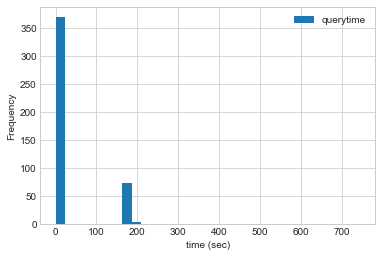

In [24]:
queryTime = %sql select querytime from results;
tplt = queryTime.DataFrame().plot.hist(bins=32)
# tplt.set_yscale('log')
tplt.set_xlabel('time (sec)')
# split this into proven and witnessed

 * postgresql://postgres@localhost:3333/postgres
90 rows affected.


Text(0.5, 0, 'time (min)')

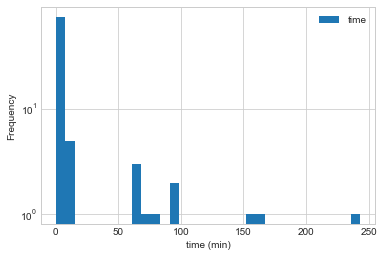

In [25]:
# Job runtimes
runtimes = %sql select ended - started as time from jobs where ended is not NULL;
runtimesDF = runtimes.DataFrame()
runtimesDF['time'] = runtimesDF['time'].apply(lambda x: x.total_seconds() / (60))
tplt = runtimesDF.plot.hist(bins=32)
tplt.set_yscale('log')
tplt.set_xlabel('time (min)')

 * postgresql://postgres@localhost:3333/postgres
90 rows affected.


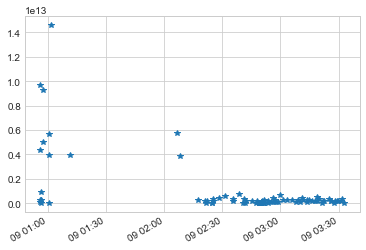

In [26]:
# Plot job time trend
rtvt = %sql select started, ended - started as time from jobs where ended is not NULL;
rtvtDF = rtvt.DataFrame()
rtvtDF.sort_values('started', ascending=True)
fig, ax = plt.subplots()
ax.plot_date(rtvtDF['started'], rtvtDF['time'], marker='*', linestyle='')

fig.autofmt_xdate()
plt.show()


Total job time

In [27]:
%%sql
select sum(ended-started) from jobs where ended is not NULL;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


sum
22:38:19.832000


In [28]:
%%sql
select sum(querytime)/60./60. from results;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


?column?
4.2605555555555556


In [29]:
%%sql
select now() - min(started) from jobs;

 * postgresql://postgres@localhost:3333/postgres
1 rows affected.


?column?
15:33:40.056629


Size of postgres data
=====================

In [30]:
%%sql
WITH RECURSIVE pg_inherit(inhrelid, inhparent) AS
    (select inhrelid, inhparent
    FROM pg_inherits
    UNION
    SELECT child.inhrelid, parent.inhparent
    FROM pg_inherit child, pg_inherits parent
    WHERE child.inhparent = parent.inhrelid),
pg_inherit_short AS (SELECT * FROM pg_inherit WHERE inhparent NOT IN (SELECT inhrelid FROM pg_inherit))
SELECT table_schema
    , TABLE_NAME
    , row_estimate
    , pg_size_pretty(total_bytes) AS total
    , pg_size_pretty(index_bytes) AS INDEX
    , pg_size_pretty(toast_bytes) AS toast
    , pg_size_pretty(table_bytes) AS TABLE
  FROM (
    SELECT *, total_bytes-index_bytes-COALESCE(toast_bytes,0) AS table_bytes
    FROM (
         SELECT c.oid
              , nspname AS table_schema
              , relname AS TABLE_NAME
              , SUM(c.reltuples) OVER (partition BY parent) AS row_estimate
              , SUM(pg_total_relation_size(c.oid)) OVER (partition BY parent) AS total_bytes
              , SUM(pg_indexes_size(c.oid)) OVER (partition BY parent) AS index_bytes
              , SUM(pg_total_relation_size(reltoastrelid)) OVER (partition BY parent) AS toast_bytes
              , parent
          FROM (
                SELECT pg_class.oid
                    , reltuples
                    , relname
                    , relnamespace
                    , pg_class.reltoastrelid
                    , COALESCE(inhparent, pg_class.oid) parent
                FROM pg_class
                    LEFT JOIN pg_inherit_short ON inhrelid = oid
                WHERE relkind IN ('r', 'p')
             ) c
             LEFT JOIN pg_namespace n ON n.oid = c.relnamespace
  ) a
  WHERE oid = parent
) a
ORDER BY total_bytes DESC limit 5;

 * postgresql://postgres@localhost:3333/postgres
5 rows affected.


table_schema,table_name,row_estimate,total,index,toast,table
public,apks,0.0,95 MB,0 bytes,95 MB,8192 bytes
public,results,430.0,3024 kB,72 kB,2400 kB,552 kB
pg_catalog,pg_depend,7725.0,1120 kB,624 kB,None,496 kB
pg_catalog,pg_proc,3034.0,1024 kB,336 kB,8192 bytes,680 kB
public,resultdata,51.0,952 kB,16 kB,912 kB,24 kB


Inspection of exceptions
========================

In [ ]:
%%sql
select id,config::json->'apkPath',replace(stderr,'$','\$') from jobs where stderr like '%Exception%';

In [ ]:
#count of total results
%sql select count(*) as Total_locations_computed from results